<a href="https://colab.research.google.com/github/greengerong/awesome-llm/blob/main/colab/autogen/autogen_kimi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 环境安装

In [2]:
!mkdir autogen
%cd /content/autogen
!touch OAI_CONFIG_LIST
!pip install pyautogen
!pip install -qqq matplotlib numpy

/content/autogen


In [32]:
import autogen
import datetime
import os
from autogen import AssistantAgent, UserProxyAgent,config_list_from_json,ConversableAgent
import tempfile
from autogen.coding import DockerCommandLineCodeExecutor,LocalCommandLineCodeExecutor
from IPython.display import Image

config_list = config_list_from_json(env_or_file="OAI_CONFIG_LIST")
llm_config={"config_list": config_list}

# Create a temporary directory to store the code files.
temp_dir = tempfile.TemporaryDirectory()

# Create a local command line code executor.
executor = LocalCommandLineCodeExecutor(
    timeout=10,  # Timeout for each code execution in seconds.
    work_dir=temp_dir.name,  # Use the temporary directory to store the code files.
)

# Create an agent with code executor configuration.
code_executor_agent = ConversableAgent(
    "code_executor_agent",
    system_message="Reply 'TERMINATE' in the end when code execute success.",
    llm_config=False,  # Turn off LLM for this agent.
    code_execution_config={"executor": executor},  # Use the local command line code executor.
    human_input_mode="NEVER",  # ALWAYS: Always take human input for this agent for safety.
    is_termination_msg=lambda msg: msg.get("content") is not None and "Great!" in msg["content"],
)


# The code writer agent's system message is to instruct the LLM on how to use
# the code executor in the code executor agent.
code_writer_system_message = """You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feedback or perform any other action beyond executing the code you suggest. The user can't modify your code. So do not suggest incomplete code which requires users to modify. Don't use a code block if it's not intended to be executed by the user.
If you want the user to save the code in a file before executing it, put # filename: <filename> inside the code block as the first line. Don't include multiple code blocks in one response. Do not ask users to copy and paste the result. Instead, use 'print' function for the output when relevant. Check the execution result returned by the user.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
When you find an answer, verify the answer carefully. Include verifiable evidence in your response if possible.
Reply 'TERMINATE' in the end when everything is done.
"""

code_writer_agent = ConversableAgent(
    "code_writer_agent",
    system_message=code_writer_system_message,
    llm_config=llm_config,
    code_execution_config=False,  # Turn off code execution for this agent.
)


# chat_result = code_executor_agent.initiate_chat(
#     code_writer_agent,
#     message="Write Python code to calculate the 14th Fibonacci number.",
# )



today = datetime.datetime.now().strftime("%Y-%m-%d")
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}. Write Python code to plot TSLA's and META's "
    "stock price gains YTD, and save the plot to a file named 'stock_gains.png'.Reply successfully saved when everything is done",
)


code_executor_agent (to code_writer_agent):

Today is 2024-04-14. Write Python code to plot TSLA's and META's stock price gains YTD, and save the plot to a file named 'stock_gains.png'.Reply successfully saved when everything is done

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
code_writer_agent (to code_executor_agent):

```python
# filename: plot_stock_gains.py

import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime

# Define the start of the year
start_of_year = datetime(2024, 1, 1)

# Fetch the stock data for TSLA and META
tsla_data = yf.download('TSLA', start=start_of_year, auto_adjust=True)
meta_data = yf.download('META', start=start_of_year, auto_adjust=True)

# Calculate the YTD gains
tsla_gain = (tsla_data['Close'][0] - tsla_data['Close'].iloc[-1]) / tsla_data['Close'][0] * 100
meta_gain = (meta_data['Close'][0] - meta_data['Close'].iloc[-1]) / meta_data['Close'][0] * 100

# Create 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<TemporaryDirectory '/tmp/tmp0ddqm1cf'>


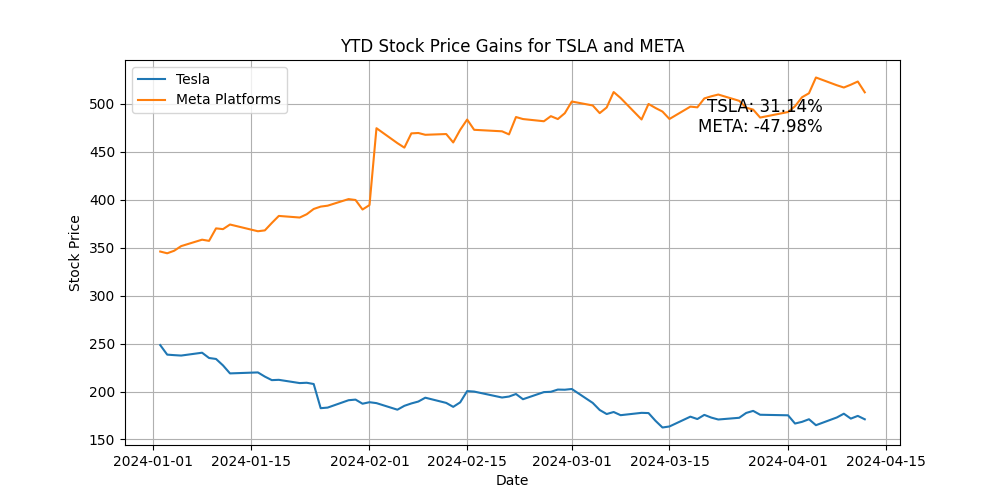

In [33]:
import os
from IPython.display import Image
print(temp_dir)

Image(os.path.join(temp_dir.name, "stock_gains.png"))

In [35]:
temp_dir.cleanup()
!rm -rf /content/autogen/OAI_CONFIG_LIST